
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain wave families from historical wave partitions
### In this case, two swell systems, one local sea

inputs required: 
  * Historical wave conditions (CSIRO partition hindcast)
  * Wave families sectors; the split is based on wave direction
  
in this notebook:
  * Split energy based on defined sectors  
  * For each TC in r1, add variable with TC category within +-12 h of Hs max

<div>
<img src="fig_esquemas/b_waveFamilies.png" width="900px">
</div>

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
from datetime import datetime
import matplotlib.pyplot as plt

# pip
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.waves import GetDistribution_gow as GetDistribution



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_hindcast')


In [8]:
# --------------------------------------
# load data and set parameters

WVS_pts = db.Load_WAVES_partitions_CSIRO()  # waves partitions data CSIRO
print(WVS_pts)

_, TCs_r1_params = db.Load_TCs_r1_hist()   # TCs historical parameters inside big radius

# wave families sectors
fams_sectors = [(45, 125), (125, 205)]

# date limits for TCs removal from waves data, and TC time window (hours)
tc_rm_date1 = '1979-01-01'
tc_rm_date2 = '2019-12-31'
tc_time_window = 12


<xarray.Dataset>
Dimensions:    (time: 363048)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2020-05-31T23:00:00
    longitude  float32 167.73355
    latitude   float32 8.66686
Data variables:
    phs0       (time) float32 nan 0.49800003 0.79200006 ... 1.3100001 1.33 1.342
    phs1       (time) float32 nan nan nan nan nan ... 0.3 0.27400002 0.272 0.27
    phs2       (time) float32 nan nan nan ... 0.21400002 0.21800001 0.21000001
    phs3       (time) float32 nan nan nan nan nan ... 0.14 0.164 0.162 0.158
    ptp0       (time) float32 nan 2.71 3.48 4.08 ... 5.97 5.89 5.87 5.91
    ptp1       (time) float32 nan nan nan nan nan ... 10.98 10.84 10.84 10.84
    ptp2       (time) float32 nan nan nan nan nan ... 8.3 8.29 8.29 8.28
    ptp3       (time) float32 nan nan nan nan ... 10.16 14.299999 14.2 14.049999
    pdir0      (time) float32 nan 70.0 73.0 77.0 78.0 ... 86.0 87.0 87.0 88.0
    pdir1      (time) float32 nan nan nan nan nan ... 183.0 182.0 182.0 182.0
    pdir2 

Text(0.5, 1.0, 'Hs CSIRO partitions')

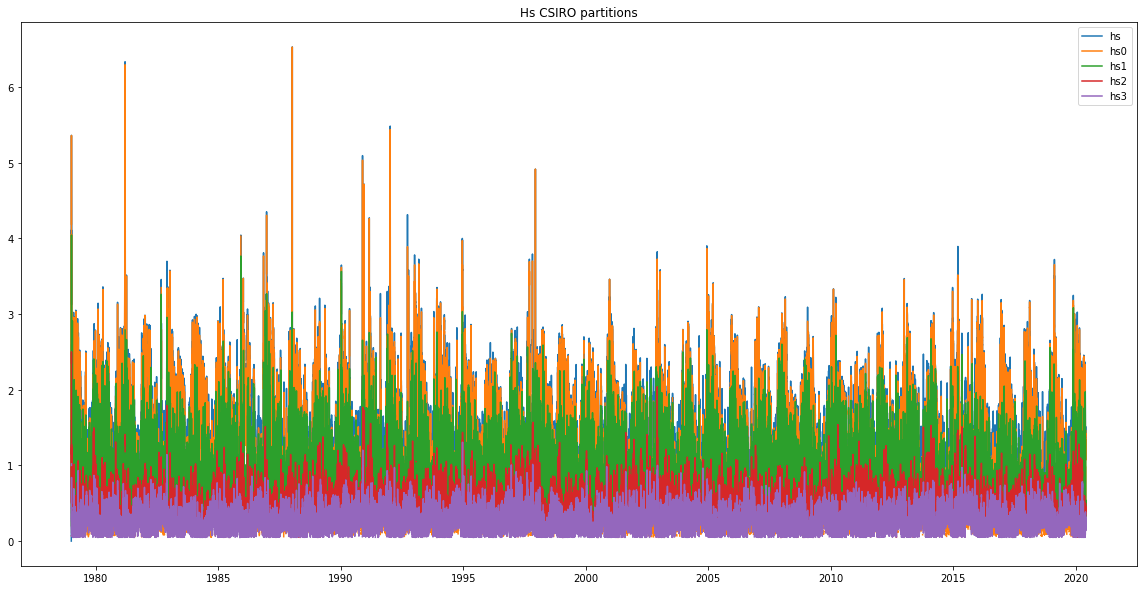

In [4]:
plt.figure(figsize=(20,10))
plt.plot(WVS_pts.time, WVS_pts.hs, label='hs')
plt.plot(WVS_pts.time, WVS_pts.phs0, label='hs0')
plt.plot(WVS_pts.time, WVS_pts.phs1, label='hs1')
plt.plot(WVS_pts.time, WVS_pts.phs2, label='hs2')
plt.plot(WVS_pts.time, WVS_pts.phs3, label='hs3')
plt.legend()
plt.title('Hs CSIRO partitions')


## Calculate Historical Waves Families

In [5]:
# --------------------------------------
# Calculate wave families from waves partitions data and waves sectors

WVS = GetDistribution(WVS_pts, fams_sectors, n_partitions=3)
print(WVS)


<xarray.Dataset>
Dimensions:      (time: 363048)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2020-05-31T23:00:00
Data variables:
    Hs           (time) float32 0.0 0.50200003 0.79800004 ... 1.378 1.396 1.406
    Tp           (time) float32 nan 2.717391 3.4843206 ... 8.130081 8.064516 8.0
    Dir          (time) float32 nan 69.700005 73.1 76.8 ... 88.8 88.700005 89.6
    sea_Hs       (time) float32 nan 0.49800003 0.79200006 ... 1.33 1.342
    sea_Tp       (time) float32 nan 2.71 3.48 4.08 ... 5.97 5.89 5.87 5.91
    sea_Dir      (time) float32 nan 70.0 73.0 77.0 78.0 ... 86.0 87.0 87.0 88.0
    swell_1_Hs   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Tp   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Dir  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_2_Hs   (time) float64 nan nan nan nan nan ... 0.3 0.3193 0.3166 0.3128
    swell_2_Tp   (time) float64 nan nan nan nan nan ... 10


## TCs: Waves  Selection 

In [16]:
# --------------------------------------
# Locate TCs and set category alongside WAVES data  

# remove TCs before 1979 and after 2019 (r1)
dds = TCs_r1_params.dmin_date.values[:]
ix = np.where((dds >= np.datetime64(tc_rm_date1)) & (dds <= np.datetime64(tc_rm_date2)))[0]
TCs_r1_params = TCs_r1_params.isel(storm=ix)

# select storms inside big circle 
storms_sel = TCs_r1_params.storm.values[:]

# add TCs category alongside WAVES data
WVS['TC_category'] = (('time',), np.empty(len(WVS.time))*np.nan)

for s in storms_sel:

    # waves at storm dates
    ss = TCs_r1_params.sel(storm=s)     
    wvs_s = WVS.sel(time = slice(ss.dmin_date, ss.last_date))
    
    # get hs_max date 
    t_hs_max = wvs_s.where(wvs_s.Hs ==  wvs_s.Hs.max(), drop=True).time.values[:][0]
        
    # hs_max time window 
    w1 = t_hs_max - np.timedelta64(tc_time_window,'h')
    w2 = t_hs_max + np.timedelta64(tc_time_window,'h')
    
    # set category alongside WAVES data
    ixs = np.where((WVS.time >= w1) & (WVS.time <= w2))[0]
    WVS['TC_category'][ixs] = ss.category

print(WVS)
    
# Store historical WAVES data
db.Save_WAVES_hist(WVS)


<xarray.Dataset>
Dimensions:      (time: 363048)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2020-05-31T23:00:00
Data variables:
    Hs           (time) float32 0.0 0.50200003 0.79800004 ... 1.378 1.396 1.406
    Tp           (time) float32 nan 2.717391 3.4843206 ... 8.130081 8.064516 8.0
    Dir          (time) float32 nan 69.700005 73.1 76.8 ... 88.8 88.700005 89.6
    sea_Hs       (time) float32 nan 0.49800003 0.79200006 ... 1.33 1.342
    sea_Tp       (time) float32 nan 2.71 3.48 4.08 ... 5.97 5.89 5.87 5.91
    sea_Dir      (time) float32 nan 70.0 73.0 77.0 78.0 ... 86.0 87.0 87.0 88.0
    swell_1_Hs   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Tp   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_1_Dir  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    swell_2_Hs   (time) float64 nan nan nan nan nan ... 0.3 0.3193 0.3166 0.3128
    swell_2_Tp   (time) float64 nan nan nan nan nan ... 10